# Setup

This section is for setup, imports, loading data, etc., that is needed prior to modeling. Please do not grade it :)

#### Base Library Imports

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
%matplotlib inline



#### Load Data

In [2]:
df = pd.read_csv('../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)

#### Transformations

In [3]:
# %%time

# Convert age into years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

# re-encode gender to 1 (male) and 0 (female)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

# compute the body mass index based on weight and height
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

# create a BMI group
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

# bin blood pressure groups based on the api hi/ lo variables
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)



In [4]:
# Full Model
# X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# New Feature Model
X_cols = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Store feature matrix 
X = df_clean[X_cols] #.to_numpy()
# Store response vector
y = df_clean['cardio'] #.to_numpy()



# Create Models (50 points)

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 



In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import time

## PipeLine and Cross Validation

The below cell analyzes performance of 3 classifiers to determine whether a patient may have cardiovascular disease.  Each of the 3 classifiers uses default parameters. A grid search here will be conducted and analyzed in later cells.  The 3 classifiers analyzed include a Logistic Regression model, a Stochastic Gradient Descent (SGD) model, and a Full Support Vector Classifier (SVC) model.  Each of the models consists of all original and new features having standardized values.  The RobustScaler() function from the scikit-learn python package is used to standardize values between features.  The RobustScaler() function scales features using statistical analysis that is robust to outliers in a dataset.  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

A one-hot encoding (OHE) has been implemented to standardize attributes such as gender and active.  However, since these categorical attributes were recorded as binary variables when read from the dataset, OHE is not expected to impact the performance of the classifiers.  For example, gender, originally recorded as 1 and 2, was re-encoded as 0 and 1.  Stated sufficiently, OHE may be redundant but could help if additional classes are added in the future.  We did also verify that there was no noticeable difference in measures of accuracy when using this technique when compared to the original binary attributes.  Nor did the use of the drop first parameter affect these metrics, which would have made our interpretation of the feature importance section less intuitive.

Each of the models are analyzed using an 80/20 train/test split.  A 10-fold Cross-Validation (CV) is included with each of the classifiers.

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = LogisticRegression(random_state=1)
clf2 = SGDClassifier(random_state=1)
clf3 = SVC(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])
                  
pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'SGD', 'SVC']

# Note n_jobs below. Setting it to -1 will create cv number of threads
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc',
                             n_jobs=-1)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.77 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.77 (+/- 0.00) [SGD]
ROC AUC: 0.77 (+/- 0.01) [SVC]


Using the ROC AUC metric to measure performance between classifiers, each model performs equally.  Indeed, the only apparent difference is that the SVC model value is within +/- 0.01, whereas the others are within +/- 0.00.
A variety of different parameters may be adjusted to improve performance of each of the models.  For example, instead of using the RobustScaler() function, the StandardScalar() function may be implemented from the scikit-learn python package.  The StandardScalar() function removes the mean and scales to a unit variance to standardize the data. 
(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).  

Otherwise, individual parameters for each of the models may be tuned to improve performance.  For example, the below cell executes the GridSearchCV() function from the scikit-learn python package to tune model parameters to improve performance of each of the models. 

The GridSearchCV() function compares the possible combinations of the parameters to achieve the best performing model.  Specifically, the GridSearchCV() function uses a “fit” and a “score” analysis to find estimators for optimized, specified parameter values.  
(https://scikit-learn.org/stable/modules/grid_search.html#grid-search.)  

As shown, the logistic regression model parameters being compared in the GridSearchCV() function are logistic C values and logistic penalty values.  Likewise, the parameters being compared in the SGD model include α values, loss values, class weight values, and penalty values.  The linear SVC model compared the C, penalty, and loss parameters to optimize performance of the model.  Lastly, an SVC model comparing 2 kernel parameters was included in the analysis.  The optimized values for each of the varied parameters are shown.  As seen in the output, the GridSearchCV() function provided some separation between the classifiers.  Specifically, the SVC model performed best having a slight increase in performance over the performance of the classifiers without the GridSearchCV() function.



## Grid Search

In [7]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = LogisticRegression(random_state=1)
clf2 = SGDClassifier(n_jobs=-1, random_state=1)
clf3 = LinearSVC(random_state=1)
clf4 = SVC(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['sgd', clf2]])

pipe3 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['linear_svc', clf3]])

pipe4 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['svc', clf4]])

model_params = {
    "logistic_regression": {
        "model": pipe1,
        "params": {
            "logistic__C": [.01, .1, 1, 5, 10, 25, 50],
            "logistic__penalty": ['l1','l2']
        }
    },
    "sgd": {
        "model": pipe2,
        "params": {
            "sgd__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
            "sgd__loss": ['hinge','log'],
            "sgd__class_weight": ["balanced", None],
            "sgd__penalty": ['l1','l2']
        }
    },
    "linear_svc": {
        "model": pipe3,
        "params": {
            "linear_svc__C": [.01, .1, 1, 5, 10, 25, 50],
            "linear_svc__penalty": ['l1','l2'],
            "linear_svc__loss": ['hinge','squared_hinge']
        }
    },
    "svc": {
        "model": pipe4,
        "params": [
            {'svc__kernel': ['linear'], 'svc__C': [1, 10]},
            {'svc__kernel': ['rbf'], 'svc__C': [1, 10], 'svc__gamma': [0.001, 0.0001]},
        ]
    }
}

scores = []

for model_name, mp in model_params.items():
    start = time.time()
    clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=10, scoring="roc_auc", n_jobs=-1)
    clf.fit(X_train, y_train)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best ROC AUC": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time
    })

In [8]:
# Although not pretty, it's quick and easy to read
print('10 Fold Cross Validation Scores:')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores:

Model :  logistic_regression
Best ROC AUC :  0.7695052453315474
Best Params :  {'logistic__C': 0.01, 'logistic__penalty': 'l2'}
Mean Fit Time:  0.17170815638133458
Mean Score Time:  0.006740522384643554
Cross Validation Time :  6.882747411727905

Model :  sgd
Best ROC AUC :  0.7707436683311993
Best Params :  {'sgd__alpha': 0.1, 'sgd__class_weight': 'balanced', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Mean Fit Time:  0.286240873336792
Mean Score Time:  0.010514105558395385
Cross Validation Time :  31.35773777961731

Model :  linear_svc
Best ROC AUC :  0.7693806410123221
Best Params :  {'linear_svc__C': 25, 'linear_svc__loss': 'hinge', 'linear_svc__penalty': 'l2'}
Mean Fit Time:  2.382295190436499
Mean Score Time:  0.005184010096958706
Cross Validation Time :  174.73681449890137

Model :  svc
Best ROC AUC :  0.7780974932743966
Best Params :  {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Mean Fit Time:  159.23044736385347
Mean Score Time:  5.

# Model Advantages (10)
Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Each of the classifiers output similar scores with slight variation between them.  The logistic regression model had a ROC AUC score of 0.7695, whereas the SGD and linear SVC models had scores of 0.7707 and 0.7694, respectively.  As stated above, the best performing model was the SVC model that had a ROC AUC score of 0.7781.  Therefore, while the SVC model scored best, the improved performance does not indicate that the performance is superior to the others.

While all these scores are similar and close together, the time needed to run each of the models varies.  The mean fit and scores times, and the cross-validation times differ significantly between models.  For example, the mean fit time for the logistic regression model is 0.3632 seconds, whereas the mean fit time for the linear SVC and SVC models have fit times of 7.7961 second and 400.3548 seconds, respectively.  The fit time for the SGD model is 0.6603.  The score times for each of the models are relatively similar except for SVC model.  Each of the score times for the logistic regression, SGD, linear SVC and SVC are 0.0104, 0.0199, 0.01568, and 13.3632, respectively.  Lastly, the cross-validation time for each of the models varied significantly with the SVC model being the longest at 1723.5489 seconds compared to 4.9318 seconds of the logistic regression model.  The SGD model performs faster than the linear SVC model because the linear SVC includes an additional 5-fold cross-validation, which increases the processing time. (https://scikit-learn.org/stable/modules/svm.html).  

As discussed, the performance of each of the models does not significantly differ while the time needed to run does vary significantly.  This impacts efficiency of each of the models.  For example, the best performing SVC model took the longest to run, and the improved difference in performance is not significant over the much faster logistic regression model.  Therefore, since the logistic regression model has less than a point difference in performance, but a much faster processing time, the logistic regression model is the most efficient model.


# Interpret Feature Importance (30)

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?


Using the parameters found from the GridSearch() function, a logistic regression model is executed in the below cell.


In [9]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

logreg = LogisticRegression(penalty='l2',
                          C=.01,
                          random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', logreg]])

fit = pipe1.fit(X_train, y_train)

In [10]:
# https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api/57534118#57534118
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

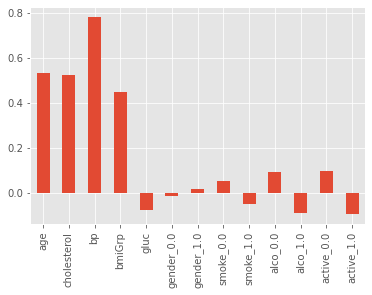

In [12]:
plt.style.use('ggplot')

weightNames = get_transformer_feature_names(pipe1['preprocessor'])
weights = pd.Series(pipe1['logistic'].coef_[0], index=weightNames)
weights.plot(kind='bar')

In [24]:
# sort these attributes and spit them out
zip_vars = zip(pipe1['logistic'].coef_[0].T, weightNames) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', round(coef, 3)) # now print them out

age has weight of 0.529
cholesterol has weight of 0.521
bp has weight of 0.782
bmiGrp has weight of 0.447
gluc has weight of -0.079
gender_0.0 has weight of -0.014
gender_1.0 has weight of 0.014
smoke_0.0 has weight of 0.053
smoke_1.0 has weight of -0.053
alco_0.0 has weight of 0.091
alco_1.0 has weight of -0.091
active_0.0 has weight of 0.097
active_1.0 has weight of -0.097


The above graph depicts feature weights for each of the features in the logistic regression model.  Based on the above graph, the features that contribute significantly to this model include “Age,” “Cholesterol,” “Blood Pressure” and the” BMI Group”. Other attributes, like “Gender,” “Smoking,” “Alcohol” and “Activity” don't appear to as strong of indicators for the presence of cardiovascular disease.  For example, each of the features “Age,” “Cholesterol, “Blood Pressure” and the” BMI Group” have strong weights that positively extend to around 0.5.  Likewise, some of the remaining features have some positive extending weights, such as “Smoking,” “Alcohol” and “Activity.”  These weights, however, only appear to extend to around 0.1.  

Using common domain knowledge, the features “Age,” “Cholesterol,” “Blood Pressure” and the” BMI Group” appear to be consistent with attributes that would contribute significantly to predicting the presence of cardiovascular disease.  For example, as a person ages, so does the heart tissue, which would likely result in more cardiovascular injuries.  Similarly, a high cholesterol value is indicative of a high presence of a substance commonly known to cause artery blockage. Lastly, a similar analysis applies to the “Blood Pressure” and the” BMI Group” features.  As the value in each of those features increases, the likelihood of cardiovascular injury also increases, for example through increased arterial pressure or a high body mass.  The other positively extending features also depict that some behaviors, such as smoking and alcohol intake, and inactivity may contribute slightly to the presence of cardiovascular disease.  This also matches the common domain knowledge of cardiovascular disease causes.  The below cell executes a further logistic regression model using the 4, strongest, weighted features to analyze changes in model performance.

In [25]:
# New Feature Model
X_cols_reduced = ['age', 'cholesterol', 'bp', 'bmiGrp']

# Store feature matrix 
X_reduced = df_clean[X_cols_reduced] #.to_numpy()
# Store response vector
y_reduced = df_clean['cardio'] #.to_numpy()

X_train, X_test, y_train, y_test =\
    train_test_split(X_reduced, y_reduced,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

logreg = LogisticRegression(penalty='l2',
                          C=.01,
                          random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', logreg]])

fit = pipe1.fit(X_train, y_train)

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



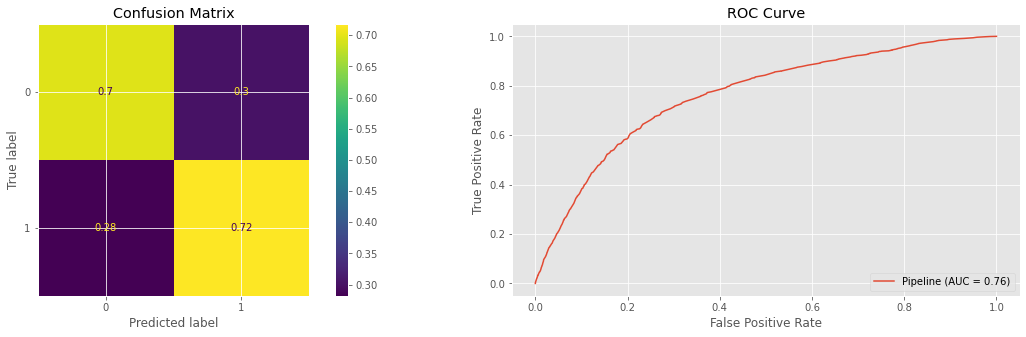

In [26]:
y_pred = fit.predict(X_test)
print(classification_report(y_test, y_pred))

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

# Pass Fitted Model, and our test sets, see how they do
plot_confusion_matrix(pipe1, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(pipe1, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()

The above accuracy value, confusion matrix, and ROC curve depict that performance of the logistic regression model with the features “Age,” “Cholesterol, “Blood Pressure” and the” BMI Group” is nearly identical to the full model.  For example, the ROC AUC value is 0.76, or identical to the initial logistic regression model.  Likewise, the accuracy value is similar to the previous logistic regression model at 0.71.  Therefore, based on the above analysis, the reduced complexity logistic regression model provides the most interpretable, and efficient classifier to predict the presence of cardiovascular disease.

# Interpret Support Vectors (10)

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

In [27]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm = SVC(kernel='linear', C=1, random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['svm', svm]])

fit = pipe1.fit(X_train, y_train)

Below we output the support vector information. Our dataset had about 70K records, and below we see that we have about half that number in support vectors. Consistent with what was discussed in class, quoting Dr. Drew "Because the way support vector machines is designed it's only going to pick up, it's only going to make a support vector for either a zeta or slack variable or an instance a training record instance that falls right along the decision boundary. That's the only thing it needs to say to make its decision."

In [28]:
print(svm.support_vectors_.shape)
print(svm.support_.shape)
print(svm.n_support_ )

(38933, 13)
(38933,)
[19469 19464]
